In [1]:
# imports
import numpy as np
import pandas as pd
import os, sys, pdb, pytz
import matplotlib.pyplot as plt
from urllib.request import urlretrieve

# matplotlib stuff
%matplotlib inline
plt.rcParams.update({"text.usetex": True, "font.family": "Helvetica"})

# astropy 
import astropy.units as u
from astropy.wcs import WCS
from astropy.time import Time
from astropy.table import QTable
from astroquery.gaia import Gaia
import astropy.coordinates as coord
from gammapy.maps import RegionGeom
from astropy.coordinates import SkyCoord
from regions import CircleSkyRegion
from astropy.visualization.wcsaxes import WCSAxes

In [2]:
# GBT information 
beamLabel = ["L","S","C","X"]
upp = [1.73, 2.60, 7.8, 11.6]
low = [1.15, 1.73, 3.95, 7.8]
beams = [12.6/x for x in upp]
beamdeg =[x/60.0 for x in beams]
beamDict = dict(zip(beamLabel, beamdeg))
freqDict = dict(zip(beamLabel, upp))

In [3]:
# set the data directory
datdir = os.path.realpath('__file__' + "/../data/") + "/"
if not os.path.isdir(datdir):
    os.mkdir(datdir)
print("Data directory: " + datdir)

Data directory: /Users/michael/Desktop/seti-fortuitous-obs/data/


In [4]:
# function to fix the arrays that were written as strings
def string_to_array(string_data):
    cleaned_data = string_data.strip('[]\n').split()
    return np.array([float(value) for value in cleaned_data])

In [5]:
# function to read csv and parse appropriate strings as arrays
def read_csv(datfile):
    # set names of columns to fix
    cols_to_fix = ['ra_trans', 'dec_trans', 'sep_trans', \
               'maxdrift_trans', 'ra_rec', 'dec_rec', \
               'sep_rec', 'maxdrift_rec']

    # read the data
    df = pd.read_csv(datfile)
    
    # turn long strings back into arrays
    for col_name in cols_to_fix:
        arr = []
        for i in range(len(df)):
            arr.append(string_to_array(df.loc[i,col_name]))
        df[col_name] = arr
        
    return df

In [6]:
# download the data if they aren't already there
datfile = datdir + "fortuitous.csv"
if not os.path.isfile(datfile):
    url = "https://zenodo.org/record/8357446/files/fortuitous.csv?download=1"
    urlretrieve(url, datfile)

# read the file
df = read_csv(datfile)

In [7]:
# function to download gaia tbl
def get_gaia_stars(max_dist=(100.0 * u.pc)):
    # construct the query
    query = f"SELECT source_id, ra, dec, parallax, distance_gspphot, pmra, pmdec, radial_velocity \
             FROM gaiadr3.gaia_source \
             WHERE distance_gspphot <= {max_dist.value}\
             AND ruwe <1.4"

    # submit the query and get results
    job = Gaia.launch_job_async(query)
    return job.get_results()

In [8]:
# read in gaia data, download if it's not present
gaiafile = datdir + "gaia.ecsv"
if not os.path.isfile(gaiafile):
    gaia_tbl = get_gaia_stars()
    gaia_tbl.write(gaiafile, overwrite=True)
else:
    gaia_tbl = QTable.read(gaiafile)

In [9]:
def format_dec_string(coord):
    fs = 1
    if coord < 0:
        fs = -1
        coord = abs(coord)
    qS = '"'
    return f"{int(fs*float(int(coord)))}$^\circ$ {int((coord - float(int(coord))) // (1/60))}' {np.around((coord - float(int(coord)) - ((coord - float(int(coord))) // (1/60))*(1/60))/(1/(60*60)),3)}{qS} "

def format_ra_string(coord):
    return f"{int(coord // 15)}h {int((coord - (coord // 15)*15) // 0.25)}m {np.around((coord - (coord // 15)*15 - ((coord - (coord // 15)*15) // 0.25)*0.25)/(360/(24*60*60)),3)}s"

In [10]:
# define function to plot focal lines on sky
def plot_probe_focal_lines(i):
    ra_trans = df.iloc[i].ra_trans
    dec_trans = df.iloc[i].dec_trans

    ra_rec = df.iloc[i].ra_rec
    dec_rec = df.iloc[i].dec_rec

    ra_obs = df.iloc[i].ra_obs
    dec_obs = df.iloc[i].dec_obs
    band = df.iloc[i].obs_band

    # make region
    c_obs = SkyCoord(ra_obs, dec_obs, unit="deg", frame="icrs")
    angle = (beamDict[band]/2.0) * u.deg
    # region = RegionGeom(CircleSkyRegion(center=c_obs, radius=angle))
    region = CircleSkyRegion(center=c_obs, radius=angle)

    wcs = RegionGeom(CircleSkyRegion(center=c_obs, radius=angle)).wcs

    # convert to pixel
    pixel_region = region.to_pixel(wcs)
    artist = pixel_region.as_artist()

    # initialize the figure
    fig = plt.figure()
    axs = plt.subplot(projection=wcs)

    # plot the beam
    axs.add_artist(artist)

    # annotate the beam circle
    label_pos = wcs.world_to_pixel(c_obs.directional_offset_by(280.0 * u.deg, 1.15 * angle))
    label = axs.annotate(band, xy=label_pos, fontsize=18)

    # get pixel coordas
    c_trans = SkyCoord(ra_trans, dec_trans, unit="deg", frame="icrs")
    x_trans, y_trans = wcs.world_to_pixel(c_trans)

    c_rec = SkyCoord(ra_rec, dec_rec, unit="deg", frame="icrs")
    x_rec, y_rec = wcs.world_to_pixel(c_trans)

    # plot the focal lines
    axs.plot(x_trans, y_trans, color="tab:blue", ls="--", label=r"{\rm Transmitter}")
    axs.plot(x_rec, y_rec, color="tab:orange", ls="-.", label=r"{\rm Receiver}")

    # get axis limits
    c1 = c_obs.directional_offset_by(0.0 * u.deg, 1.25 * angle)
    c2 = c_obs.directional_offset_by(90.0 * u.deg, 1.25 * angle)
    c3 = c_obs.directional_offset_by(180.0 * u.deg, 1.25 * angle)
    c4 = c_obs.directional_offset_by(270.0 * u.deg, 1.25 * angle)

    all_coords = [c1, c2, c3, c4, *c_trans, *c_rec]

    x_coords = []
    y_coords = []
    for i in range(len(all_coords)):
        out = wcs.world_to_pixel(all_coords[i])
        x_coords.append(out[0])
        y_coords.append(out[1])

    x_coords = np.array(x_coords)
    y_coords = np.array(y_coords)
        
    # fix the axes
    axs.set_xlim(np.min(x_coords)-0.1, np.max(x_coords)+0.1)
    axs.set_ylim(np.min(y_coords)-0.1, np.max(y_coords)+0.1)

    # set the axis labels
    axs.set_xlabel(r"{\rm Right Ascension}", fontsize=12)
    axs.set_ylabel(r"{\rm Declination}", fontsize=12)

    axs.set_aspect("equal")
    axs.grid(ls="--", alpha=0.5)
    axs.legend(fontsize=12)
    fig.savefig("/Users/michael/Desktop/the_sky_is_a_sphere.pdf")
    plt.show()

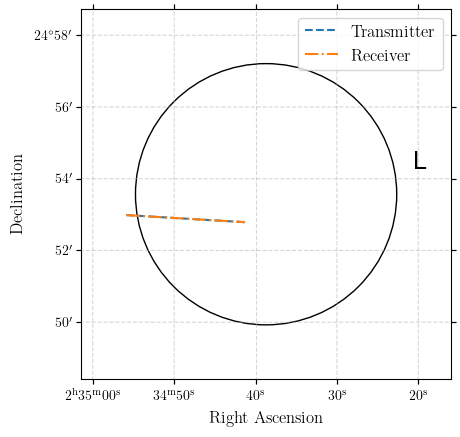

In [11]:
# plot the first hit
plot_probe_focal_lines(1)

In [12]:
# get gaia source ids that appear in observation list
common_ids = set(gaia_tbl["source_id"]).intersection(df["gaia_source_id"])

idx = []
for i in common_ids:
    idx.append(np.where(gaia_tbl["source_id"] == i)[0][0])

# get maximum proper motion
gaia_pmra = gaia_tbl[idx]["pmra"]
gaia_pmdec = gaia_tbl[idx]["pmdec"]
gaia_pm = np.sqrt(gaia_pmra**2.0 + gaia_pmdec**2.0)
pm_idx = np.argmax(gaia_pm)
gaia_maxpm_source_id = gaia_tbl["source_id"][idx[pm_idx]]

print("Largest proper motion: " + str(gaia_pm[pm_idx]))

Largest proper motion: 661.4666883026124 mas / yr


994


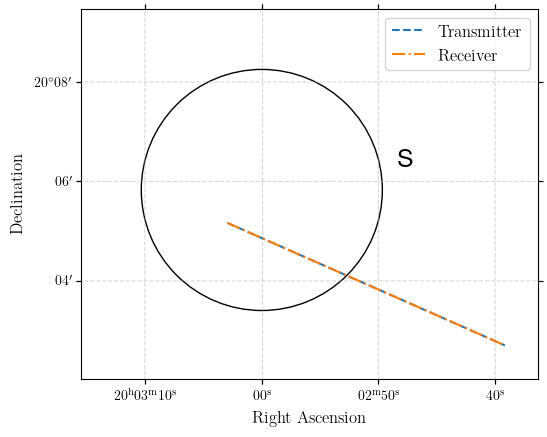

In [13]:
# get corresponding observation index
idx = np.where(df["gaia_source_id"].values == gaia_maxpm_source_id)[0][0]
print(idx)

# plot focal lines for star with largest proper motion
plot_probe_focal_lines(idx)

In [14]:
# get maximum drift rates
max_drift = np.zeros(len(df))

for i in range(len(df)):
    idx_trans = np.argmax(np.abs(df.loc[i, "maxdrift_trans"]))
    idx_rec = np.argmax(np.abs(df.loc[i, "maxdrift_rec"]))
    max_drift_trans = df.loc[i, "maxdrift_trans"][idx_trans]
    max_drift_rec = df.loc[i, "maxdrift_rec"][idx_rec]

    temp_drift = [max_drift_trans, max_drift_rec]
    
    idx = np.argmax(np.abs(temp_drift))
    max_drift[i] = temp_drift[idx]


In [15]:
# discriminate drift rates by observations bands
L_idx = df["obs_band"] == "L"
S_idx = df["obs_band"] == "S"
C_idx = df["obs_band"] == "C"
X_idx = df["obs_band"] == "X"

max_drift_L = max_drift[L_idx]
max_drift_S = max_drift[S_idx]
max_drift_C = max_drift[C_idx]
max_drift_X = max_drift[X_idx]

Text(0, 0.5, 'Probability Density')

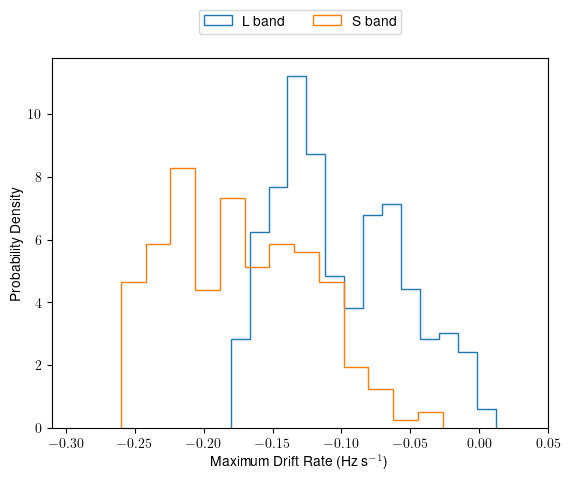

In [16]:
# plot disttributions of max drift rates
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)

ax1.hist(max_drift_L, histtype="step", color="tab:blue", bins="auto", label="L band", density=True)
ax1.hist(max_drift_S, histtype="step", color="tab:orange", bins="auto", label="S band", density=True)
# ax1.hist(max_drift_C, histtype="step", color="tab:green", bins="auto", label="C band", density=True)
# ax1.hist(max_drift_X, histtype="step", color="tab:brown", bins="auto", label="X band", density=True)

ax1.set_xlim(np.min(max_drift_S) - 0.05, 0.05)
ax1.legend(bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=4)
ax1.set_xlabel("Maximum Drift Rate (Hz s$^{-1}$)")
ax1.set_ylabel("Probability Density")

In [17]:
print(len(max_drift_L))
print(len(max_drift_S))
# print(len(max_drift_C))
# print(len(max_drift_X))

1080
684


In [18]:
print(np.median(max_drift_L))
print(np.median(max_drift_S))
# print(np.median(max_drift_C))
# print(np.median(max_drift_X))

-0.112706505
-0.18043715500000002


In [19]:
# determine separation between beginning and end of focal line
frac_contained_trans = []
frac_contained_rec = []

# loop over rows
for index, row in df.iterrows():
    # if index != 720:
    #     continue
    
    # alias the coordinates
    ra_trans0 = row.ra_trans
    dec_trans0 = row.dec_trans
    ra_rec0 = row.ra_rec
    dec_rec0 = row.dec_rec

    # make sky coord objects
    c_trans = SkyCoord(ra_trans0 * u.deg, dec_trans0 * u.deg)
    c_rec = SkyCoord(ra_rec0 * u.deg, dec_rec0 * u.deg)

    # calculate angular separation between 550 AU and inf to get length of focal line
    len_trans = np.max(c_trans[0].separation(c_trans[1:])).degree
    len_rec = np.max(c_rec[0].separation(c_rec[1:])).degree

    # get coordinate of obs 
    ra_obs = row.ra_obs
    dec_obs = row.dec_obs
    c_obs = SkyCoord(ra_obs * u.deg, dec_obs * u.deg)

    # get separation between obs and probes
    seps_trans = c_obs.separation(c_trans)
    seps_rec = c_obs.separation(c_rec)

    # get indices of obs within beam fwhm 
    band = row.obs_band
    fwhm = beamDict[band]
    idx_trans = np.array(seps_trans.degree <= (fwhm / 2.0))
    idx_rec = np.array(seps_rec.degree <= (fwhm / 2.0))

    # get separation between first and last points contained in focal line
    if sum(idx_trans) > 1:
        idx1 = np.where(idx_trans)[0][0]
        idx2 = np.where(idx_trans)[0][-1]
    else:
        idx1 = np.where(idx_trans)[0][0]
        idx2 = idx1 + 1

    sep_contained_trans = c_trans[idx1].separation(c_trans[idx2]).degree
    frac_contained_trans.append(sep_contained_trans / len_trans)

    if sum(idx_rec) > 1:
        idx1 = np.where(idx_rec)[0][0]
        idx2 = np.where(idx_rec)[0][-1]
    else:
        idx1 = np.where(idx_trans)[0][0]
        idx2 = idx1 + 1

    sep_contained_rec = c_rec[idx1].separation(c_rec[idx2]).degree
    frac_contained_rec.append(sep_contained_rec / len_rec)

0.3570428349738551
0.360172590372901


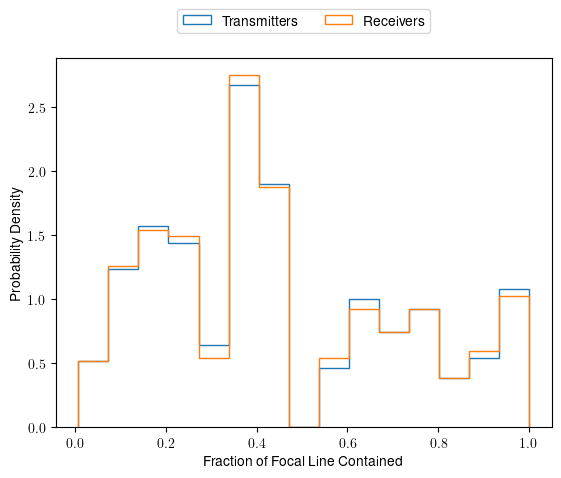

In [20]:
# plot distribution of fraction of focal line contained
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)

ax1.hist(frac_contained_trans, histtype="step", color="tab:blue", bins="auto", label="Transmitters", density=True)
ax1.hist(frac_contained_rec, histtype="step", color="tab:orange", bins="auto", label="Receivers", density=True)

ax1.legend(bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=4)
ax1.set_xlabel("Fraction of Focal Line Contained")
ax1.set_ylabel("Probability Density")

print(np.median(frac_contained_trans))
print(np.median(frac_contained_rec))

In [21]:
print(np.argmax(frac_contained_trans))
print(np.argmin(frac_contained_trans))
print(frac_contained_rec[157])

43
157
0.007643056429498376


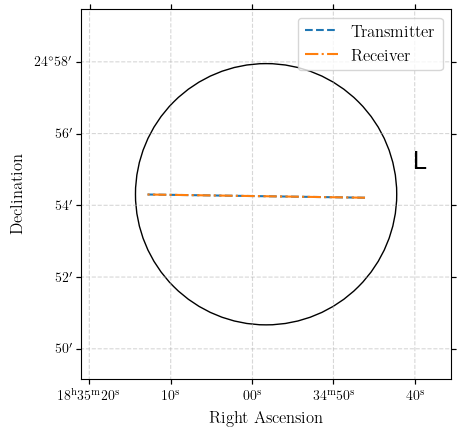

In [22]:
# plot the observation with largest fraction contained
idx = np.argmax(frac_contained_trans)
plot_probe_focal_lines(idx)

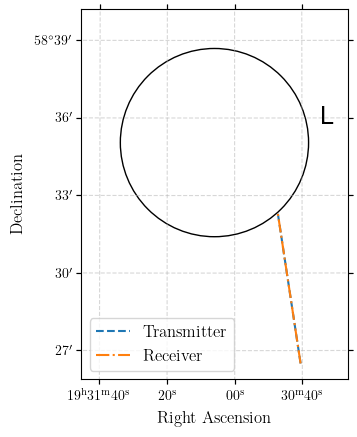

In [23]:
idx = np.argmin(frac_contained_trans)
plot_probe_focal_lines(idx)